# Imports

In [56]:
import numpy as np
from scipy.io import loadmat
from scipy.fft import fft, fftfreq
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import math
from statistics import mean
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# TESTING .mat file

Load test

In [57]:
data = loadmat('Data/train_data_1.mat')

 Show the data test

In [58]:
user_vars = {k: v for k, v in data.items() if not k.startswith('__')}

for key, value in user_vars.items():
    print(f"\n--- {key} ---")
    print(f"Type: {type(value)}")
    print("Shape:", getattr(value, "shape", "N/A"))

    # Print scalar values or array samples
    if isinstance(value, np.ndarray):
        if value.ndim == 0:
            print("Scalar value:", value.item())
        elif value.ndim == 1:
            print("First 5 elements:", value[::])
        elif value.ndim == 2:
            print("First 5 rows:\n", value[::])
        elif value.ndim == 3:
            print("First 5 slices along axis 0:\n", value[:5])


--- channels ---
Type: <class 'numpy.ndarray'>
Shape: (7,)
First 5 elements: ['F3' 'F4' 'Fz' 'C3' 'C4' 'Cz' 'Pz']

--- fs ---
Type: <class 'numpy.ndarray'>
Shape: (1, 1)
First 5 rows:
 [[128]]

--- data ---
Type: <class 'numpy.ndarray'>
Shape: (288, 1920, 7)
First 5 slices along axis 0:
 [[[ 158.65887621  -40.93540601  -60.65252916 ...  259.24820604
    -63.47535199  -32.21123372]
  [ 155.3602066   -47.43275047  -62.33666314 ...  255.04493307
    -66.78496375  -29.23758656]
  [ 153.6532714   -50.26994114  -66.64789913 ...  251.72664108
    -68.04001645  -29.6722016 ]
  ...
  [ -11.53179161   -8.78207989   -6.81586856 ...   -1.05662389
    -12.1903469     0.41410004]
  [ -14.68037102   -8.68984428   -4.82200136 ...   -0.85407445
    -15.27431229   -1.70154376]
  [ -17.30795586  -13.54489686   -8.04649496 ...   -7.18342427
    -20.66120881   -3.96859021]]

 [[ -14.58824193  -19.21987525  -10.41882248 ...  -10.82545612
    -25.08487698   -4.73698357]
  [ -15.90785163  -15.70998555   -8.5

# Load Subjects

In [59]:
Train = []
Test = []
for i in range(1,6):
    Train.append(loadmat(f'Data/train_data_{i}.mat'))
    Test.append(loadmat(f'Data/test_data_{i}.mat'))

In [60]:
len(Test)

5

# 1. Common Average Reference filter

Apply Common Average Reference (CAR) filter to the (EEG) data <br>
Input shape: (n_trials, n_samples, n_channels) <br> output shape: (n_trials, n_samples, n_channels)

In [61]:
def apply_car_filter(data):
    # Compute mean across channels for each trial and time sample
    car_data = data - data.mean(axis=2, keepdims=True)
    return car_data

## CAR Filter To Subjects

In [62]:
Train_filtered = []
Test_filtered = []
for i in range(0,5):
    Temp_train = Train[i]
    Temp_test = Test[i]
    Temp_test['data'] = apply_car_filter(Test[i]['data'])
    Temp_train['data'] = apply_car_filter(Train[i]['data'])
    Train_filtered.append(Temp_train)
    Test_filtered.append(Temp_test)

In [63]:
Train_filtered[0]['labels']

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1]])

# 2. For each electrode

## 2.1. For each trial of each class of attention

In [64]:
BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta':  (13, 30),
    'gamma': (30, 45)
}

### 2.1.1 Compute the Fourier Transform of the trial signal

In [65]:
def compute_fft(signal, fs):
    fft_vals = fft(signal)
    freqs = fftfreq(len(signal), d=1/fs)
    power = np.abs(fft_vals) ** 2
    return freqs, power

### 2.1.2 Compute the power in each of the delta, theta, alpha, beta, and gamma bands as the mean of the power of the frequencies in each band

In [66]:
def compute_band_powers(freqs, power):
    band_powers = []
    for band_range in BANDS.values():
        low, high = band_range
        mask = (freqs >= low) & (freqs <= high) & (freqs >= 0)
        band_power = power[mask].mean()
        band_powers.append(band_power)
    return band_powers

## 2.2 Form a feature vector as required in each deliverable in the project description

In [67]:
def extract_features_per_class(data_class, fs):
    n_trials, _, n_channels = data_class.shape
    all_features = []

    for ch in range(n_channels):  # For each electrode
        ch_features = []
        for trial in range(n_trials):  # For each trial
            signal = data_class[trial, :, ch]
            freqs, power = compute_fft(signal, fs)                
            band_powers = compute_band_powers(freqs, power)        
            ch_features.append(band_powers)  
        all_ch_features = np.array(ch_features)  
        all_features.append(ch_features)

    return np.hstack(all_features)

In [68]:
extract_features_per_class(Train_filtered[0]['data'], Train_filtered[0]['fs'][0][0])[0][4]

13485.523094918175

## 2.3 Apply K-Nearest Neighbor (KNN) classifier examining K from 1 to 10 using the training and test datasets

In [76]:
def evaluate_combs(Train_filtered, Test_filtered, k_range=list(range(1,11))):
    results = {}
    for sub in range(len(Train_filtered)):
        print(f"\n===== Subject {sub + 1} =====")
        data_train = extract_features_per_class(Train_filtered[sub]['data'], Train_filtered[sub]['fs'][0][0])
        data_test  = extract_features_per_class(Test_filtered[sub]['data'],  Test_filtered[sub]['fs'][0][0])
        labels_train = Train_filtered[sub]['labels'][0]
        labels_test  = Test_filtered[sub]['labels'][0]
        n_channels = Train_filtered[sub]['data'].shape[2]
        n_bands = data_train.shape[1]

        data_train_resh = data_train.reshape(data_train.shape[0], n_channels, n_bands)
        data_test_resh  = data_test.reshape(data_test.shape[0],  n_channels, n_bands)

        strategies = ['bands_per_channel', 'channels_per_band', 'all_channels_bands']
        for strategy in strategies:
            if strategy == 'bands_per_channel':
                for ch in range(n_channels):
                    X_train = data_train_resh[:, ch, :]
                    X_test  = data_test_resh[:, ch, :]
                    # CONCAT
                    best_acc, best_k = 0, 0
                    for k in k_range:
                        clf = KNeighborsClassifier(n_neighbors=k)
                        clf.fit(X_train, labels_train)
                        acc = accuracy_score(labels_test, clf.predict(X_test))
                        if acc > best_acc:
                            best_acc, best_k = acc, k
                    results[(sub+1, strategy, f'ch{ch+1}_raw')] = (best_acc, best_k)
                    print(f"Channel {ch+1} CONCAT accuracy: {best_acc:.3f}, K: {best_k}")

                    # MEAN
                    X_train_mean = np.mean(X_train, axis=1).reshape(-1, 1)
                    X_test_mean  = np.mean(X_test, axis=1).reshape(-1, 1)
                    best_acc, best_k = 0, 0
                    for k in k_range:
                        clf = KNeighborsClassifier(n_neighbors=k)
                        clf.fit(X_train_mean, labels_train)
                        acc = accuracy_score(labels_test, clf.predict(X_test_mean))
                        if acc > best_acc:
                            best_acc, best_k = acc, k
                    results[(sub+1, strategy, f'ch{ch+1}_mean')] = (best_acc, best_k)
                    print(f"Channel {ch+1} MEAN accuracy: {best_acc:.3f}, K: {best_k}")

                    # MEDIAN
                    X_train_med = np.median(X_train, axis=1).reshape(-1, 1)
                    X_test_med  = np.median(X_test, axis=1).reshape(-1, 1)
                    best_acc, best_k = 0, 0
                    for k in k_range:
                        clf = KNeighborsClassifier(n_neighbors=k)
                        clf.fit(X_train_med, labels_train)
                        acc = accuracy_score(labels_test, clf.predict(X_test_med))
                        if acc > best_acc:
                            best_acc, best_k = acc, k
                    results[(sub+1, strategy, f'ch{ch+1}_median')] = (best_acc, best_k)
                    print(f"Channel {ch+1} MEDIAN accuracy: {best_acc:.3f}, K: {best_k}")

                    # PCA
                    for n_comp in [2, 3, 4]:
                        pca = PCA(n_components=n_comp)
                        X_train_pca = pca.fit_transform(X_train)
                        X_test_pca  = pca.transform(X_test)
                        best_acc, best_k = 0, 0
                        for k in k_range:
                            clf = KNeighborsClassifier(n_neighbors=k)
                            clf.fit(X_train_pca, labels_train)
                            acc = accuracy_score(labels_test, clf.predict(X_test_pca))
                            if acc > best_acc:
                                best_acc, best_k = acc, k
                        results[(sub+1, strategy, f'ch{ch+1}_pca_{n_comp}')] = (best_acc, best_k)
                        print(f"Channel {ch+1} PCA_{n_comp} accuracy: {best_acc:.3f}, K: {best_k}")
            elif strategy == 'channels_per_band':
                for b in range(n_bands):
                    X_train = data_train_resh[:, :, b]
                    X_test  = data_test_resh[:, :, b]
                    # CONCAT
                    best_acc, best_k = 0, 0
                    for k in k_range:
                        clf = KNeighborsClassifier(n_neighbors=k)
                        clf.fit(X_train, labels_train)
                        acc = accuracy_score(labels_test, clf.predict(X_test))
                        if acc > best_acc:
                            best_acc, best_k = acc, k
                    results[(sub+1, strategy, f'band{b+1}')] = (best_acc, best_k)
                    print(f"Band {b+1} CONCAT accuracy: {best_acc:.3f}, K: {best_k}")

                    # MEAN
                    X_train_mean = np.mean(X_train, axis=1).reshape(-1, 1)
                    X_test_mean  = np.mean(X_test, axis=1).reshape(-1, 1)
                    best_acc, best_k = 0, 0
                    for k in k_range:
                        clf = KNeighborsClassifier(n_neighbors=k)
                        clf.fit(X_train_mean, labels_train)
                        acc = accuracy_score(labels_test, clf.predict(X_test_mean))
                        if acc > best_acc:
                            best_acc, best_k = acc, k
                    results[(sub+1, strategy, f'band{b+1}_mean')] = (best_acc, best_k)
                    print(f"Band {b+1} MEAN accuracy: {best_acc:.3f}, K: {best_k}")

                    # MEDIAN
                    X_train_med = np.median(X_train, axis=1).reshape(-1, 1)
                    X_test_med  = np.median(X_test, axis=1).reshape(-1, 1)
                    best_acc, best_k = 0, 0
                    for k in k_range:
                        clf = KNeighborsClassifier(n_neighbors=k)
                        clf.fit(X_train_med, labels_train)
                        acc = accuracy_score(labels_test, clf.predict(X_test_med))
                        if acc > best_acc:
                            best_acc, best_k = acc, k
                    results[(sub+1, strategy, f'band{b+1}_median')] = (best_acc, best_k)
                    print(f"Band {b+1} MEDIAN accuracy: {best_acc:.3f}, K: {best_k}")

                    # PCA
                    for n_comp in [2, 3, 4]:
                        pca = PCA(n_components=n_comp)
                        X_train_pca = pca.fit_transform(X_train)
                        X_test_pca  = pca.transform(X_test)
                        best_acc, best_k = 0, 0
                        for k in k_range:
                            clf = KNeighborsClassifier(n_neighbors=k)
                            clf.fit(X_train_pca, labels_train)
                            acc = accuracy_score(labels_test, clf.predict(X_test_pca))
                            if acc > best_acc:
                                best_acc, best_k = acc, k
                        results[(sub+1, strategy, f'band{b+1}_pca_{n_comp}')] = (best_acc, best_k)
                        print(f"Band {b+1} PCA_{n_comp} accuracy: {best_acc:.3f}, K: {best_k}")
            else:
                for method in ['mean', 'median']:
                    feat_train = np.mean(data_train, axis=1).reshape(-1, 1) if method == 'mean' else np.median(data_train, axis=1).reshape(-1, 1)
                    feat_test  = np.mean(data_test, axis=1).reshape(-1, 1)  if method == 'mean' else np.median(data_test, axis=1).reshape(-1, 1)
                    best_acc, best_k = 0, 0
                    for k in k_range:
                        clf = KNeighborsClassifier(n_neighbors=k)
                        clf.fit(feat_train, labels_train)
                        acc = accuracy_score(labels_test, clf.predict(feat_test))
                        if acc > best_acc:
                            best_acc, best_k = acc, k
                    results[(sub+1, strategy, method)] = (best_acc, best_k)
                    print(f"{method.capitalize()} accuracy: {best_acc:.3f}, K: {best_k}")

                for n_comp in [2, 3, 4]:
                    pca = PCA(n_components=n_comp)
                    X_train_pca = pca.fit_transform(data_train)
                    X_test_pca  = pca.transform(data_test)
                    best_acc, best_k = 0, 0
                    for k in k_range:
                        clf = KNeighborsClassifier(n_neighbors=k)
                        clf.fit(X_train_pca, labels_train)
                        acc = accuracy_score(labels_test, clf.predict(X_test_pca))
                        if acc > best_acc:
                            best_acc, best_k = acc, k
                    results[(sub+1, strategy, f'pca_{n_comp}')] = (best_acc, best_k)
                    print(f"PCA_{n_comp} accuracy: {best_acc:.3f}, K: {best_k}")

                X_train_concat = data_train  
                X_test_concat  = data_test
                best_acc, best_k = 0, 0
                for k in k_range:
                    clf = KNeighborsClassifier(n_neighbors=k)
                    clf.fit(X_train_concat, labels_train)
                    acc = accuracy_score(labels_test, clf.predict(X_test_concat))
                    if acc > best_acc:
                        best_acc, best_k = acc, k
                results[(sub+1, strategy, 'concat')] = (best_acc, best_k)
                print(f"All channels&bands CONCAT accuracy: {best_acc:.3f}, K: {best_k}")
    return results


In [77]:
def KNN(data_train,labels_train,data_test,k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data_train, labels_train)
    return knn.predict(data_test)

In [78]:
def classify_samp(data_train,data_test,k,labels_train,labels_test,channel, band, chb):
    n_trial, n_channel_band = data_train.shape
    ch = 0
    band = 0
    accuracy = 0
    if chb:
        labels_pred = KNN(data_train,labels_train,data_test,k)
        accuracy = accuracy_score(labels_test,labels_pred)
    elif channel:
        labels_pred = KNN(combfreqmean(data_train),labels_train,combfreqmean(data_test),k)
        accuracy = accuracy_score(labels_test,labels_pred)
    elif band:
        print(combineChannelmean(data_train).shape)
        labels_pred = KNN(combineChannelmean(data_train),labels_train,combineChannelmean(data_test),k)
        accuracy = accuracy_score(labels_test,labels_pred)
    else:
        for i in range(0,n_channel_band):
            curr_chan_band_train = data_train[:,i].reshape(-1, 1)
            curr_chan_band_test = data_test[:,i].reshape(-1, 1)
            labels_pred = KNN(curr_chan_band_train,labels_train,curr_chan_band_test,k)
            if accuracy_score(labels_test,labels_pred) > accuracy:
                accuracy = accuracy_score(labels_test,labels_pred)
                ch = math.ceil((i + 1) / 5)
                band = list(BANDS.keys())[(i % 5)]
    return accuracy , ch, band

In [79]:
def Calculate_acc(channel, band, chb):
    accuracys = []
    channels = []
    bands = []
    Ks = []
    K_error = []
    for sub in range(0,5):
        acc_graph = []
        # 288 x 35 vector
        dataTrain = extract_features_per_class(Train_filtered[sub]['data'], Train_filtered[sub]['fs'][0][0])
        dataTest = extract_features_per_class(Test_filtered[sub]['data'], Test_filtered[sub]['fs'][0][0])
        labelsTrain = Train_filtered[sub]['labels'][0]
        labelsTest = Test_filtered[sub]['labels'][0]
        for k in range(1,11):
            acc , ch, band = classify_samp(dataTrain,dataTest,k,labelsTrain,labelsTest,channel, band, chb)
            acc_graph.append(acc)
            if k == 1:
                accuracys.append(acc)
                channels.append(ch)
                bands.append(band)
                Ks.append(k)
                K_error.append(1 - acc)
            elif accuracys[sub] < acc:
                accuracys[sub] = acc
                channels[sub] = ch
                bands[sub] = band
                Ks[sub] = k
                K_error[sub] = 1 - acc
        plt.plot(range(1,11),acc_graph, marker='o',color='blue')
        plt.title(f"Accuracy vs value of k for subject {sub + 1}")
        plt.xlabel("K")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()
    return accuracys,channels,bands,Ks,K_error

In [80]:
dataTrain = extract_features_per_class(Train_filtered[0]['data'], Train_filtered[0]['fs'][0][0])
# combfreq(dataTrain).shape


C:\Users\arwam\AppData\Local\Temp\ipykernel_11732\774444310.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


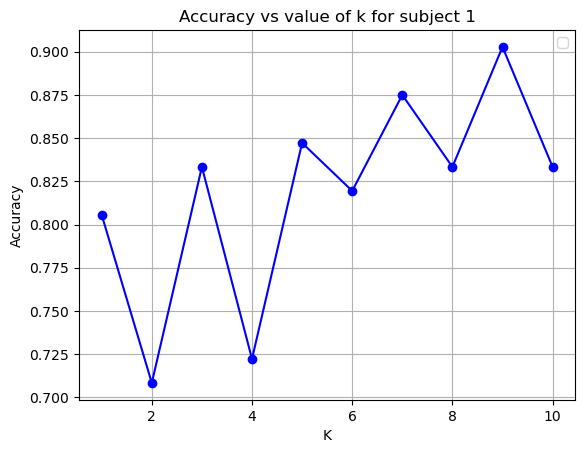

C:\Users\arwam\AppData\Local\Temp\ipykernel_11732\774444310.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


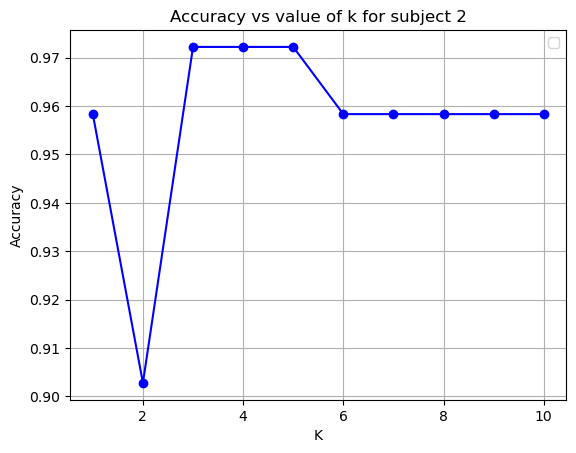

In [ ]:
accuracys, channels, bands, Ks, K_error = Calculate_acc(channel=False, band=False, chb=False)
print("Accuracys: ", accuracys)
print("Channels: ", channels)
print("Bands: ", bands)
print("Ks: ", Ks)
print("K_error: ", K_error)

In [ ]:
results = evaluate_combs(Train_filtered, Test_filtered)
